In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

---

In [8]:
glm = 2
dir_glm = su.get_dir_glm(glm)

In [9]:
list_nn = su.get_list_sn()
list_subj = []
for sess in ['S','R']:
    for nn in list_nn:
        list_subj.append(sess+nn)
list_subj

['S01',
 'S02',
 'S03',
 'S05',
 'S06',
 'S08',
 'S09',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'R01',
 'R02',
 'R03',
 'R05',
 'R06',
 'R08',
 'R09',
 'R10',
 'R11',
 'R12',
 'R13',
 'R14']

---

### Calculate $R^{2}$ score

In [10]:
# subj = 'S01'
# glob(join(dir_glm,subj,'hrf_tune/*.beta.*.nii'))

In [10]:
tmp = {'subj':[], 'sess':[], 'roi':[], 'param':[], 'r2':[]}
for subj in tqdm(list_subj):
    sess = subj[0]
    nn = subj[1:]
    fnames = sorted(glob(join(dir_glm,subj,'hrf_tune/*.y_hat.*.nii')))
    for fname in fnames:
        _, hemi, _, param, _, roi, _, _, _= fname.split('/')[-1].split('.')
        df_tmp = simage.get_df_y(subj=subj, glm=glm, roi=roi, param=param, hemi=hemi)
        r2 = r2_score(y_true=df_tmp.y_adj, y_pred=df_tmp.y_hat)
        tmp['subj'].append(nn)
        tmp['sess'].append(sess)
        tmp['roi'].append(roi)
        tmp['param'].append(str(param).replace(' ',''))
        tmp['r2'].append(r2)
df = pd.DataFrame(tmp)
del tmp

100%|███████████████████████████████████████████████████████████████████████████| 24/24 [2:35:54<00:00, 389.76s/it]


In [11]:
df.to_csv(
    join(dir_glm,'r2_score.tsv'),
    sep='\t', index=False
)

---

### Load $R^{2}$ score

In [12]:
df = pd.read_csv(
    join(dir_glm,'r2_score.tsv'),
    sep='\t', header=0
)
df

,subj,sess,roi,param,r2
0,1,S,M1,"[4,13,1,1,3,0,32]",0.210487
1,1,S,PMd,"[4,13,1,1,3,0,32]",0.169299
2,1,S,PMv,"[4,13,1,1,3,0,32]",0.148567
3,1,S,S1,"[4,13,1,1,3,0,32]",0.116110
4,1,S,SMA,"[4,13,1,1,3,0,32]",0.086633
...,...,...,...,...,...
6907,14,R,S1,"[6,17,1,1,6,0,32]",0.224902
6908,14,R,SMA,"[6,17,1,1,6,0,32]",0.112210
6909,14,R,SPLa,"[6,17,1,1,6,0,32]",0.175920
6910,14,R,SPLp,"[6,17,1,1,6,0,32]",0.139237


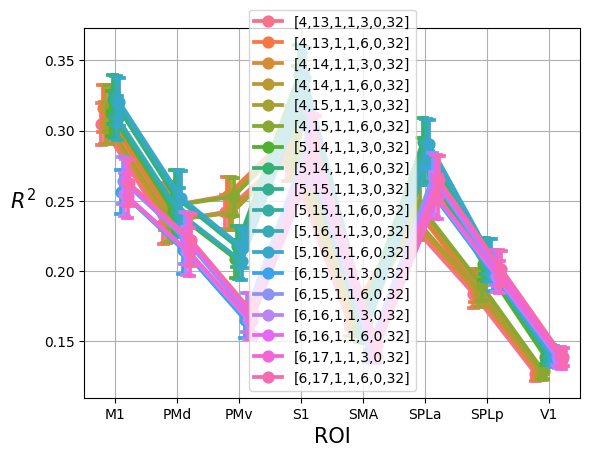

In [13]:
g = sns.pointplot(
    data=df,
    x='roi', y='r2', hue='param',
    capsize=0.15, dodge=True, errorbar='se',
    linestyles='-', 
)
g.grid(axis='both')
g.set_ylabel(r'$R^{2}$', fontsize=15, rotation=0, labelpad=15)
g.set_xlabel('ROI', fontsize=15)
g.legend(loc='best')

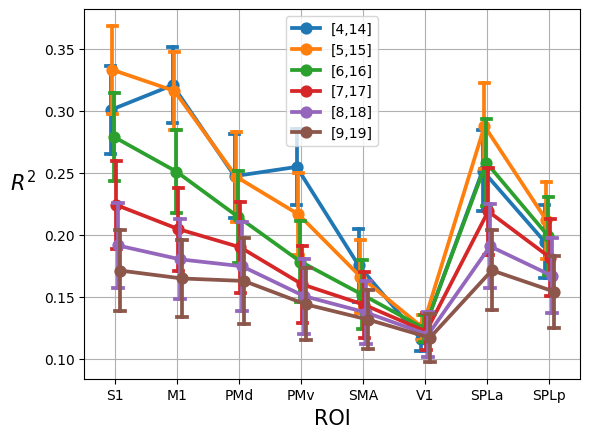

In [14]:
g = sns.pointplot(
    data=df,
    x='roi', y='r2', hue='param',
    capsize=0.15, dodge=True, errorbar='se',
    linestyles='-', 
)
g.grid(axis='both')
g.set_ylabel(r'$R^{2}$', fontsize=15, rotation=0, labelpad=15)
g.set_xlabel('ROI', fontsize=15)
g.legend(loc='best')

In [40]:
# df_max = df[df.r2==df.groupby(['subj','sess','roi'])['r2'].transform('max')]
# df_max.sort_values(by=['subj','sess','roi'], ascending=[True,False,True])

In [44]:
df_tmp = df.groupby(['subj','roi','param'], as_index=False).mean(['r2'])
df_max = df_tmp[df_tmp.r2==df_tmp.groupby(['subj','roi'])['r2'].transform('max')]
df_max.sort_values(by=['subj','roi'], ascending=[True,True])

,subj,roi,param,r2
0,1,M1,"[4,14]",0.303799
7,1,PMd,"[5,15]",0.227037
13,1,PMv,"[5,15]",0.201462
19,1,S1,"[5,15]",0.252490
25,1,SMA,"[5,15]",0.139793
...,...,...,...,...
546,14,S1,"[4,14]",0.289173
552,14,SMA,"[4,14]",0.143694
559,14,SPLa,"[5,15]",0.208415
565,14,SPLp,"[5,15]",0.163065


---